# Agent test notebook
## TODO

## Progress
- Planner finished
- Assistant need to be adjusted
- Replanner is probably needed as well
- https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/plan-and-execute/plan-and-execute.ipynb

## Issues
- Getting stuck on infinite loop with web search - improve with assisstant prompt
- YouTube videos
```
Task ID: a1e91b78-d3d8-4675-bb8d-62741b4b68a6
Question: In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?
```
- Azure Content Moderation tends to interfere

## Resources
- Instructions: https://huggingface.co/learn/agents-course/unit4/hands-on
- Leaderboard and codes: https://huggingface.co/spaces/agents-course/Students_leaderboard
    - 1 good example: https://huggingface.co/spaces/cellerson/AgentCourseFinalProject/tree/main
- GitHub models: https://github.com/marketplace?type=models

In [1]:
pip install -r requirements.txt -qU

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import requests
from typing import TypedDict, Annotated, Union, Literal, Optional, Tuple, List, Any
import base64
import mimetypes
import operator

from dotenv import load_dotenv
import pandas as pd
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage

from langgraph.errors import GraphRecursionError
from langchain_experimental.utilities import PythonREPL
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# Search tools
from langchain_community.tools import Tool, DuckDuckGoSearchRun
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

# TTS
import assemblyai as aai


load_dotenv()

api_url = "https://agents-course-unit4-scoring.hf.space"
questions_url = f"{api_url}/questions"
random_question_url = f"{api_url}/random-question"
files_url = f"{api_url}/files"
submit_url = f"{api_url}/submit"

def get_question(random: bool = True):
    """
    Get a random question from the API.
    Returns
        - question text
        - task id
        - binary file (if any)
        - file name (if any)
    """

    if random:
        used_url = random_question_url
    else:
        used_url = questions_url

    question_data = requests.get(used_url, timeout=15)
    question_data.raise_for_status()
    questions_json = question_data.json()

    # Create list if only 1 question was requested
    if not isinstance(questions_json, list):
        questions_json = [questions_json]

    for question_json in questions_json:

        question = question_json["question"]
        task_id = question_json["task_id"]

        file_name = question_json.get("file_name", None)

        if file_name:
            file_url = f"{files_url}/{task_id}"
            response = requests.get(file_url, timeout=15)
            response.raise_for_status()
            with open(os.path.join("tmp", file_name), "wb") as f:
                f.write(response.content)

        yield (question, task_id, file_name)

def read_file(file_name: str) -> Tuple[str, str | bytes]:
    """
    Returns file content as a string
    """

    file_path = os.path.join("tmp", file_name)

    mime_type, _ = mimetypes.guess_type(file_path)

    # Images
    if mime_type and mime_type.startswith("image/"):
        with open(file_path, "rb") as f:
            return "image", f.read()

    extension = file_name.split(".")[-1]
    if not extension:
        extension = "unknown"

    # Excel files
    if extension in ["xlsx", "xls"]:
        return extension, pd.read_excel(file_path).to_string()

    # mp3 files
    if extension in ["mp3"]:
        return "audio", ""

    # Anything else
    with open(file_path, "r") as f:
        return extension, f.read()

def submit_answer(submission_data: dict):
    """
    Submit the answers for checking.
    """

    try:
        response = requests.post(submit_url, json=submission_data, timeout=60)
        response.raise_for_status()
        result_data = response.json()
        final_status = (
            # f"Submission Successful!\n"
            # f"User: {result_data.get('username')}\n"
            # f"Overall Score: {result_data.get('score', 'N/A')}% "
            # f"({result_data.get('correct_count', '?')}/{result_data.get('total_attempted', '?')} correct)\n"
            # f"Message: {result_data.get('message', 'No message received.')}"
            result_data.get('score', 'N/A')
        )
        return final_status

    except requests.exceptions.HTTPError as e:
        error_detail = f"Server responded with status {e.response.status_code}."
        try:
            error_json = e.response.json()
            error_detail += f" Detail: {error_json.get('detail', e.response.text)}"
        except requests.exceptions.JSONDecodeError:
            error_detail += f" Response: {e.response.text[:500]}"
        status_message = f"Submission Failed: {error_detail}"
        return status_message

    except requests.exceptions.Timeout:
        status_message = "Submission Failed: The request timed out."
        return status_message

    except requests.exceptions.RequestException as e:
        status_message = f"Submission Failed: Network error - {e}"
        return status_message

    except Exception as e:
        status_message = f"An unexpected error occurred during submission: {e}"
        return status_message

## Initial setup

In [3]:
load_dotenv()

assistant_model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment="gpt-4.1-mini",
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

validator_model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment="gpt-4.1",
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

planning_model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    # azure_deployment="o3-mini",
    azure_deployment="gpt-4.1",
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

replanning_model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment="o3-mini",
    # azure_deployment="gpt-4.1",
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

os.environ["LANGCHAIN_TRACING_V2"] = "true"

## Tools

In [4]:
def transcribe_audio(audio_file: str) -> str:
    """Transcribes provided audio file into text"""

    load_dotenv()

    aai.settings.api_key = os.environ["ASSEMBLY_AI_API_KEY"]

    config = aai.TranscriptionConfig(speech_model=aai.SpeechModel.best)

    transcript = aai.Transcriber(config=config).transcribe(audio_file)

    if transcript.status == "error":
        print(f"Transcription failed: {transcript.error}")
        return ""

    return transcript.text


transcribe_audio_tool = Tool(
    name="audio_transcription",
    func=transcribe_audio,
    description="Returns text from an audio file"
)

### Search tool

search_tool = TavilySearchResults(max_results=3)

# search_tool = DuckDuckGoSearchRun()

# search_wrapper = GoogleSerperAPIWrapper()

# search_tool = Tool(
#         name="search_tool",
#         func=search_wrapper.run,
#         description="useful for when you need to ask with search",
#     )

### Python tool

python_repl = PythonREPL()

python_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

tools = [
    search_tool,
    python_tool,
    transcribe_audio_tool,
]

assistant_model = assistant_model.bind_tools(tools, parallel_tool_calls=False)

## State

In [5]:
class TaskState(TypedDict):

    # Input data
    question: str
    task_id: str
    file_name: Optional[str]
    file_type: Optional[str]
    file_content: Optional[bytes]

    # Output data
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    answer: str
    assistant_messages: list[AnyMessage] # Note: no automatic addition for better control
    tool_messages: list[AnyMessage] # Separated from assistant messages, because without automatic addition, tool will replace the list
    collected_knowledge: str

## Nodes

### Planner
- Starts the task processing
- Creates plan

In [6]:
class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


def planner(state: TaskState):
    """Creates step by step plan to finish defined task"""

    question = state["question"]
    file_name = state["file_name"]
    file_type = state["file_type"]
    file_content = state["file_content"]

    planner_prompt = """For the given objective, come up with a simple step by step plan.
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
    You have tools for web search, audio transcription and python code execution at your disposal. """


    ### Add file

    if file_name:

        if file_type == "image":
            image_base64 = base64.b64encode(file_content).decode("utf-8")

            system_content = [
                {"type": "text", "text": planner_prompt},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_base64}",
                    },
                }
            ]

        elif file_type == "audio":

            planner_prompt += f"""
            You can use following audio file to answer the question:
            {os.path.join('tmp', file_name)}
            """

            system_content = [{"type": "text", "text": planner_prompt}]

        else:

            planner_prompt += f"""
            You can use following information to answer the question:
            {file_content}
            """

            system_content = [{"type": "text", "text": planner_prompt}]


    else:
        system_content = [{"type": "text", "text": planner_prompt}]


    planner_messages = [
        # SystemMessage(content=planner_prompt),
        SystemMessage(content=system_content),
        HumanMessage(content=question),
    ]

    planning_model_structured = planning_model.with_structured_output(Plan)

    plan = planning_model_structured.invoke(planner_messages)

    return {
        "plan": plan.steps
    }

### Replanner
- Adjusts plan based on already done steps
- Decides when the plan is finished

In [7]:
class Answer(BaseModel):
    """Response to user."""
    response: str

class Act(BaseModel):
    """Action to perform."""
    action: Union[Answer, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


def replanner(state: TaskState):
    """Updates plan based on work already done"""

    question = state["question"]
    plan = state["plan"]
    past_steps = state["past_steps"]

    # Add last message from assistant to past steps
    if len(state["assistant_messages"]) > 0:
        last_message = state["assistant_messages"][-1]
        task = plan[0]
        past_steps.append((task, last_message.content))

    replanner_prompt = f"""For the given objective, come up with a simple step by step plan.
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

    Your objective was this:
    {question}

    Your original plan was this:
    {plan}

    You have currently done the follow steps:
    {past_steps}

    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that.
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.
    Answer has to be formatted as specified in the question.
    Be very concise and output only the answer."""

    replanner_messages = [
        SystemMessage(content=replanner_prompt),
    ]

    replanning_model_structured = replanning_model.with_structured_output(Act)

    replan = replanning_model_structured.invoke(replanner_messages)

    if isinstance(replan.action, Answer):
        return {
            "answer": replan.action.response,
            "assistant_messages": [],
            "tool_messages": []
        }
    else:
        return {
            "plan": replan.action.steps,
            "answer": "",
            "assistant_messages": [],
            "tool_messages": []
        }


def answer_provided_condition(state: TaskState)  -> Literal["validator", "assistant"]:
    """If answer was provided, proceed to validator. Otherwise give it back to rework."""

    if "answer" in state and state["answer"]:
        return "validator"
    else:
        return "assistant"

### Assistant with tools
- Can use tools
- Executes next step in the plan

In [8]:
def assistant(state: TaskState):

    file_name = state['file_name']
    file_type = state['file_type']
    file_content = state['file_content']
    tool_messages = state['tool_messages']
    assistant_messages = state['assistant_messages']
    plan = state["plan"]
    knowledge = state["collected_knowledge"]

    if len(tool_messages) > 0:
        # Add tool answer to assistant history (local for 1 task processing)
        assistant_messages.extend(tool_messages)
        # Collect gained knowledge (global for full processing)
        knowledge += "\n\n".join([str(tool_message.content) for tool_message in tool_messages]) + "\n\n"

    if len(assistant_messages) == 0:

        assistant_system_prompt = f"""
        You are an AI assistant anwering complex questions.
        Think step by step and answer following question.
        When doing web search, be very specific and precise with your queries and specify all the details - language, year, etc.
        When generating Python code, do not continue, until you generate syntatically correct code."""

        if knowledge:
            assistant_system_prompt += f"\n\nYou can use following knowledge for your answer:\n{knowledge}"


        ### Add file

        if file_name:

            if file_type == "image":
                image_base64 = base64.b64encode(file_content).decode("utf-8")

                system_content = [
                    {"type": "text", "text": assistant_system_prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}",
                        },
                    }
                ]

            elif file_type == "audio":

                assistant_system_prompt += f"""
                You can use following audio file to answer the question:
                {os.path.join('tmp', file_name)}
                """

                system_content = [{"type": "text", "text": assistant_system_prompt}]

            else:

                assistant_system_prompt += f"""
                You can use following information to answer the question:
                {file_content}
                """

                system_content = [{"type": "text", "text": assistant_system_prompt}]


        else:
            system_content = [{"type": "text", "text": assistant_system_prompt}]


        system_message = SystemMessage(
            content=system_content
        )

        plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
        task = plan[0]
        task_formatted = f"""\n\nFor the following plan:
        {plan_str}\n\nYou are tasked with executing step {1}, {task}."""

        human_message = HumanMessage(content=task_formatted)

        assistant_messages.append(system_message)
        assistant_messages.append(human_message)

    response = assistant_model.invoke(assistant_messages)
    assistant_messages.append(response)

    return {
        "tool_messages": [response],
        "assistant_messages": assistant_messages,
        "collected_knowledge": knowledge
    }


def tools_or_replanner_condition(state: TaskState) -> Literal["tools", "replanner"]:
    """
    If last message in the state is a tool call, navigate to the tools node, otherwise to the validator node.
    """

    tool_messages = state["tool_messages"]

    if len(tool_messages) > 0:
        tool_message = tool_messages[-1]
    else:
        return "replanner"

    if hasattr(tool_message, "tool_calls") and len(tool_message.tool_calls) > 0:
        return "tools"

    return "replanner"

### Validator
- TODO: structured output

In [9]:
class AnswerFeedback(BaseModel):
    """Feedback to the final answer to the question"""

    answer_accepted: bool = Field(
        description="Flag if answer to the initial question was validated. "
            "If all format and other prerequisites were fulfilled, return True. "
            "Otherwise return false to get back to processing."
    )
    answer_feedback: str = Field(
        description="In case of incorrect answer, provide explanation what need to be changed."
    )



def validator(state: TaskState):

    answer = state["answer"]

    prompt = f"""You are a format reviewer.
    Your role is to check whether the assistant's answer matches exactly the required structure.
    Except requirement directly in the question, the answer has to be short, concise and to the point.
    It should contain only the requested information without additional words.
    Focus only on formatting, not on verifying the facts or contents.
    If the format does not match, briefly explain what should be adjusted.
    If the format is correct, respond only with the word FINISHED.

    The question:
    {state["question"]}

    Assistant's answer:
    {answer}
    """

    structured_validator_model = validator_model.with_structured_output(AnswerFeedback)

    response = structured_validator_model.invoke([HumanMessage(prompt)])

    if not response.answer_accepted:
        answer = ""

    return {
        # "past_steps": [("Output format validation", response.content)], # This will be done by replanner via assistant_messages
        "tool_messages": [],
        "past_steps": [("Answer validation", response.answer_feedback)],
        "answer": answer
    }

def validator_approval_condition(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],
) -> Literal["replanner", END]:
    """
    If the last answer is not correct, let the assistant rework it.
    """

    # Check if answer stayed filled or if it was revoked and deleted
    answer = state["answer"]

    if answer:
        return END
    return "replanner"

## Graph definition

In [10]:
# Create the graph
task_graph = StateGraph(TaskState)

# Add nodes
task_graph.add_node("planner", planner)
task_graph.add_node("replanner", replanner)
task_graph.add_node("validator", validator)
task_graph.add_node("assistant", assistant)
task_graph.add_node("tools", ToolNode(
    tools=tools,
    name="tools",
    messages_key="tool_messages"
))

# Add edges
task_graph.add_edge(START, "planner")
task_graph.add_edge("planner", "assistant")
task_graph.add_conditional_edges("assistant", tools_or_replanner_condition, ["tools", "replanner"]) # Continue with tools or proceed to replanner
task_graph.add_edge("tools", "assistant")
task_graph.add_conditional_edges("replanner", answer_provided_condition, ["validator", "assistant"]) # Validate answer continue working
task_graph.add_conditional_edges("validator", validator_approval_condition, ["replanner", END]) # Go to END or back to assistant for rework

compiled_graph = task_graph.compile()

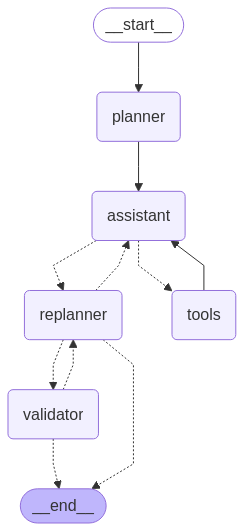

In [11]:
from IPython.display import display, Image

display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))

## Execution

In [12]:
question_generator = get_question(random=False)
all_answers_payload = []

for question, task_id, file_name in question_generator:

    if task_id != "99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3":
        continue

    answers_payload = []

    print("Task ID:", task_id)
    print("Question:", question)
    print("File Name:", file_name or "No file")

    if "youtube" in question:
        print("Youtube not implemented, skipping")
        print("=" * 100)
        continue

    file_content = None
    file_type = None
    if file_name:
        file_type, file_content = read_file(file_name)

    task_answer = None

    # Try 3 times
    for i in range(1):
        try:
            task_answer = compiled_graph.invoke(
                {
                    "question": question,
                    "task_id": "1",
                    "file_name": file_name,
                    "file_type": file_type,
                    "file_content": file_content,
                    "answer": "",
                    "tool_messages": [],
                    "assistant_messages": [],
                    "collected_knowledge": ""
                },
                {"recursion_limit": 30},
            )
        except GraphRecursionError as e:
            print("Recursion error, trying again...")
            continue
        except Exception as e:
            print("Other error, skipping question\nError details:", e)
            break
        break

    if task_answer:
        print("Answer:", task_answer["answer"])
        print("-" * 50)

        # answers_payload.append({"task_id": task_id, "submitted_answer": task_answer["answer"]})
        answers_payload = [{"task_id": task_id, "submitted_answer": task_answer["answer"]}]
        all_answers_payload.extend(answers_payload)

        # TODO: Copy the final implementation to a Hugging Face space
        submission_data = {"username": "jarisko", "agent_code": "https://github.com/jarisko1/hf_agents_course_final", "answers": answers_payload}

        final_status = submit_answer(submission_data)
        print(final_status)
        print("=" * 100)

    else:
        print("No answer produced")
        print("=" * 100)

    # break

Task ID: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3
Question: Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients.
File Name: 99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
Answer

# Tests

In [ ]:
pip install -r requirements.txt -qU

In [ ]:
from langchain.document_loaders import YoutubeLoader
from langchain.indexes import VectorstoreIndexCreator

loader = YoutubeLoader.from_youtube_url("L1vXCYZAYYM", add_video_info=False)
docs = loader.load()
print(docs)

# Test prebuilt agent

In [15]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()

tools = [TavilySearchResults(max_results=3)]

assistant_model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment="gpt-4.1",
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
)

prompt = "You are a helpful assistant."
agent_executor = create_react_agent(assistant_model, tools, prompt=prompt)

In [16]:
agent_executor.invoke({"messages": [("user", """Given this table defining * on the set S = {a, b, c, d, e}

|*|a|b|c|d|e|
|---|---|---|---|---|---|
|a|a|b|c|b|d|
|b|b|c|a|e|c|
|c|c|a|b|b|a|
|d|b|e|b|e|d|
|e|d|b|a|d|c|

provide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in the set in alphabetical order.
""")]})

{'messages': [HumanMessage(content='Given this table defining * on the set S = {a, b, c, d, e}\n\n|*|a|b|c|d|e|\n|---|---|---|---|---|---|\n|a|a|b|c|b|d|\n|b|b|c|a|e|c|\n|c|c|a|b|b|a|\n|d|b|e|b|e|d|\n|e|d|b|a|d|c|\n\nprovide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in the set in alphabetical order.\n', additional_kwargs={}, response_metadata={}, id='a92f0617-cf57-456d-b2cd-8fff979d5f5b'),
  AIMessage(content="To determine if the operation * is not commutative on the set \\( S = \\{a, b, c, d, e\\} \\), we look for any pair \\((x, y)\\) such that \\(x * y \\neq y * x\\).\n\nLet's check for counter-examples by comparing each \\(x * y\\) with \\(y * x\\):\n\n### Step-by-step:\n\n- \\(a*b = b\\), \\(b*a = b\\) (equal)\n- \\(a*c = c\\), \\(c*a = c\\) (equal)\n- \\(a*d = b\\), \\(d*a = b\\) (equal)\n- \\(a*e = d\\), \\(e*a = d\\) (equal)\n- \\(b*c = a\\), \\(c*b = a\\) (equal)\n- \

In [20]:
answers_payload = [{"task_id": "6f37996b-2ac7-44b0-8e68-6d28256631b4", "submitted_answer": "b,c,e"}]
submission_data = {"username": "jarisko", "agent_code": "https://github.com/jarisko1/hf_agents_course_final", "answers": answers_payload}
final_status = submit_answer(submission_data)
print(final_status)

0.0


Plan(steps=["Go to the 'Featured Articles' log for English Wikipedia (https://en.wikipedia.org/wiki/Wikipedia:Featured_article_candidates/Featured_log).", 'Find the section for November 2016 to see which articles were promoted that month.', 'For each article promoted in November 2016, look at the article topic/title to identify which one is about a dinosaur.', 'Once the dinosaur article is found, click through to its Featured Article Candidate (FAC) nomination page (linked from the log or via article talk page FA star).', 'On the FAC page, check the nomination statement for the user who nominated the article (their signature is usually at the top).', "The nominator's username is the answer."])